전체 프로세스 따라서 시계열 모델링 한번 해본다!

In [1]:
# Import the necessary libraries for EDA, Visualization and Time series modelling
from os.path import join
from datetime import datetime
import datetime as dt

## Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Time series analysis tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import statsmodels as sm


ModuleNotFoundError: No module named 'pmdarima'

### 전처리된 데이터 만들기

In [5]:
BASE_DIR = '/content/drive/MyDrive/wai/AI_contest/'

In [6]:
train_path = join(BASE_DIR, 'raw_data.csv')
data = pd.read_csv(train_path, index_col=0)

In [7]:
data['ds'] = pd.to_datetime(data['ds'], format='%Y%m%d')
data.set_index(pd.DatetimeIndex(data['ds']), inplace=True)
data.drop('ds', axis=1, inplace=True)

평택 송탄 폐수

In [8]:
df = data[data['local'] == '평택송탄폐수'].drop('local', axis=1)

In [9]:
cols = df.columns.to_list()
cols

['pH', 'COD', 'SS', 'N', 'P', 'T']

- 이상치를 결측으로 처리.
    - 이상치 판정 방법: IQR
-  (결측치 있는)월 포함한 전체 데이터에서 groupby 월 mean 값.
-  transformation 일단 안 하고 작업

추가. 아예 없는 날짜 - 하드코딩 안 하기(다른 사업장에도 적용할 수 있게)

In [10]:
orign_dates = pd.date_range(start=df.index[0].date(), end=df.index[-1].date())

In [11]:
none_dates = [d for d in orign_dates if d not in df.index]

In [12]:
origin_df = pd.DataFrame(columns=cols, index=orign_dates)
origin_df.index.names = ['ds']
origin_df

,pH,COD,SS,N,P,T
ds,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-01-27,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
origin_df.update(df)
origin_df

,pH,COD,SS,N,P,T
ds,,,,,,
2010-01-01,0.220542,0.406908,-0.215817,0.904258,0.489179,0.283926
2010-01-02,0.220542,0.563499,-0.215817,0.820031,0.357462,0.283926
2010-01-03,0.782144,0.459105,-0.215817,0.584288,0.193392,0.283926
2010-01-04,0.782144,0.459105,-0.215817,0.64276,0.21419,0.283926
2010-01-05,0.220542,0.406908,-0.443168,1.01308,-0.125504,0.065677
...,...,...,...,...,...,...
2018-01-27,-0.902663,-0.010668,-1.352572,-1.958763,-0.409737,-0.807318
2018-01-28,-0.341061,-0.062865,-1.352572,-2.043222,-0.349655,-0.589069
2018-01-29,-0.902663,-0.428244,-1.352572,-1.807247,-0.333479,-0.589069


In [14]:
origin_df.loc[none_dates].notnull().sum()

pH     0
COD    0
SS     0
N      0
P      0
T      0
dtype: int64

In [15]:
df = origin_df
df

,pH,COD,SS,N,P,T
ds,,,,,,
2010-01-01,0.220542,0.406908,-0.215817,0.904258,0.489179,0.283926
2010-01-02,0.220542,0.563499,-0.215817,0.820031,0.357462,0.283926
2010-01-03,0.782144,0.459105,-0.215817,0.584288,0.193392,0.283926
2010-01-04,0.782144,0.459105,-0.215817,0.64276,0.21419,0.283926
2010-01-05,0.220542,0.406908,-0.443168,1.01308,-0.125504,0.065677
...,...,...,...,...,...,...
2018-01-27,-0.902663,-0.010668,-1.352572,-1.958763,-0.409737,-0.807318
2018-01-28,-0.341061,-0.062865,-1.352572,-2.043222,-0.349655,-0.589069
2018-01-29,-0.902663,-0.428244,-1.352572,-1.807247,-0.333479,-0.589069


In [16]:
def outliers_iqr(data):
    q1 = data.quantile(q=0.25)
    q3 = data.quantile(q=0.75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # return data[(data > upper_bound) | (data < lower_bound)].index

    data[(data > upper_bound) | (data < lower_bound)] = np.nan
    return data

In [17]:
# 이상치 -> 결측치
for c in cols:
    df[c] = outliers_iqr(df[c])

In [18]:
# 결측치 -> 전 년도 해당 월 평균
for c in cols:
    for i in df[c][df[c].isnull()].index:
        df[c][dt.date.isoformat(i)] = df[c].groupby(df.index.month).mean()[i.month]

In [19]:
df.isnull().sum()

pH     0
COD    0
SS     0
N      0
P      0
T      0
dtype: int64

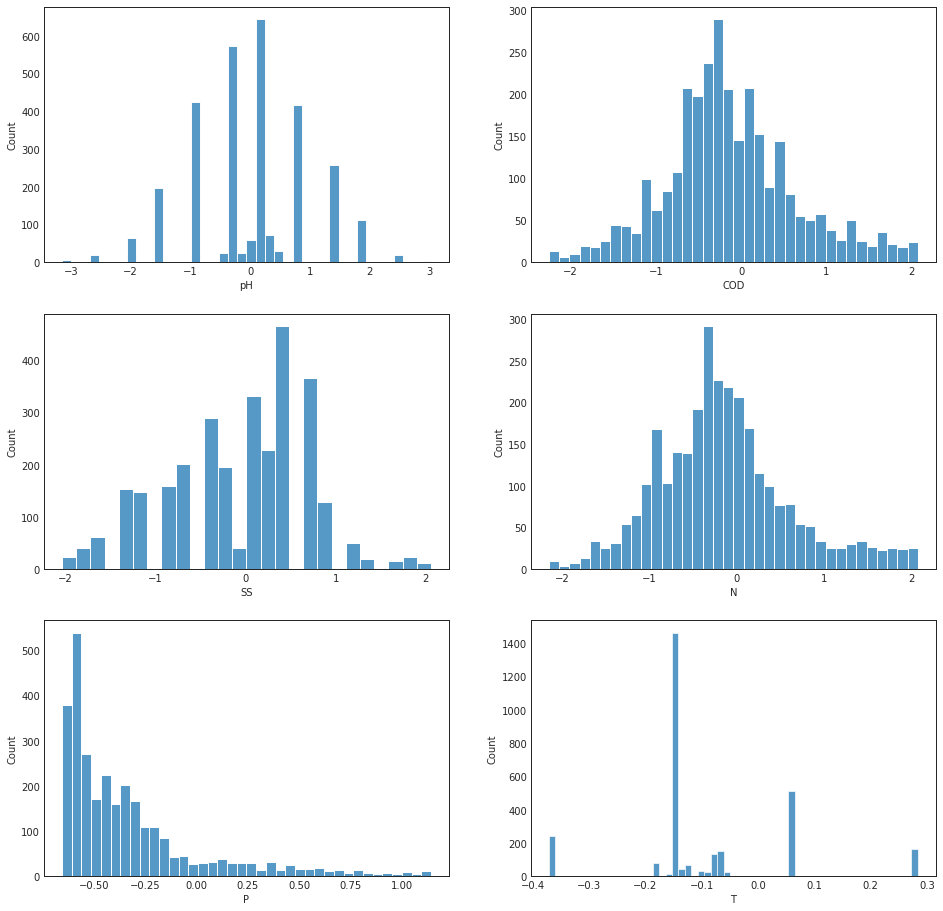

In [20]:
fig, ax=plt.subplots(3,2, figsize=(16,16))
for i,v in enumerate(cols):
    sns.histplot(ax=ax[i//2][i%2], data=df[v])

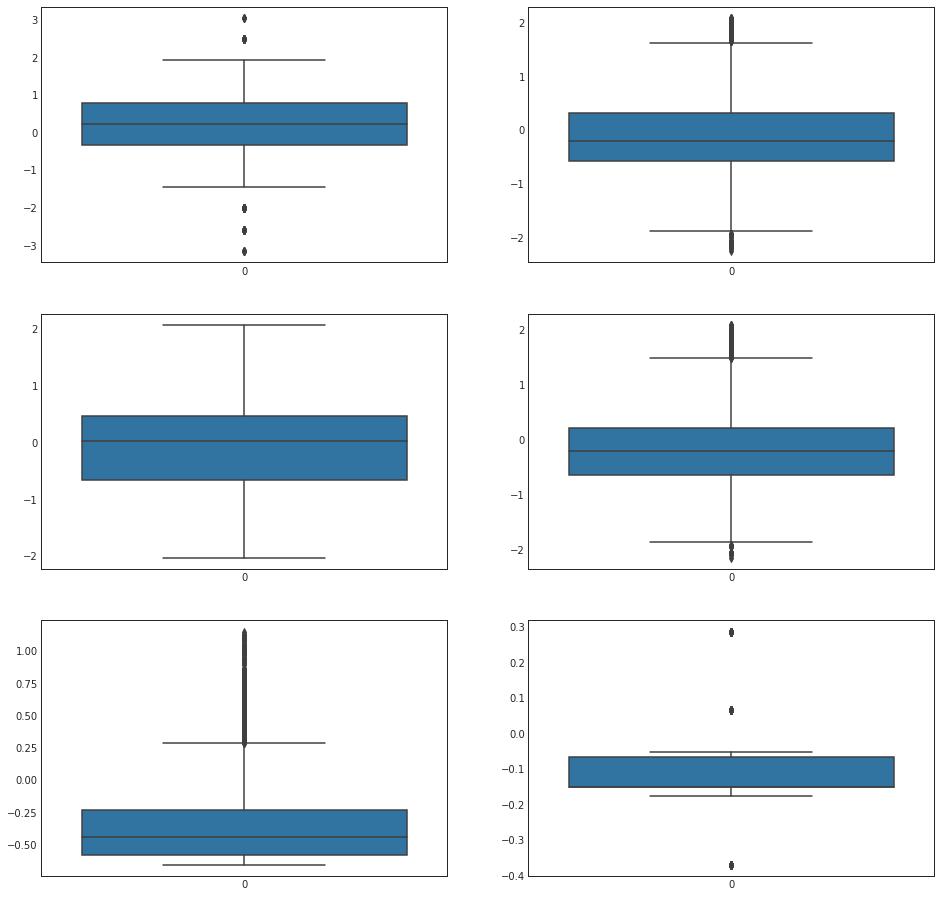

In [21]:
fig, ax=plt.subplots(3,2, figsize=(16,16))
for i,v in enumerate(cols):
    sns.boxplot(ax=ax[i//2][i%2], data=df[v])

### Box-Jenkins

Box-Jenkins ARIMA Procedure

- Data Preprocessing(transform, differencing)
- Identify Model to be Tentatively Entertained
- Estimate Parameters
- Dignosis Check
- Prediction Using Model

In [22]:
# def split_xy(dataset, time_steps, y_column):
#     x, y = list(), list()
#     for i in range(len(dataset)):
#         x_end_number = i + time_steps
#         y_end_number = x_end_number + y_column
        
#         if y_end_number > len(dataset):
#             break
#         tmp_x = dataset[i:x_end_number, :]
#         tmp_y = dataset[x_end_number:y_end_number, :]
#         x.append(tmp_x)
#         y.append(tmp_y)
#     return np.array(x), np.array(y)

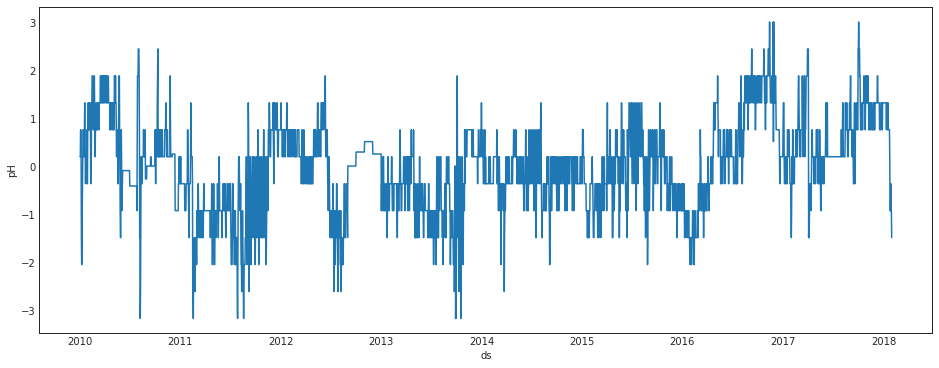

In [23]:
fig, ax=plt.subplots(figsize=(16,6))
sns.lineplot(ax=ax, data=df['pH'])

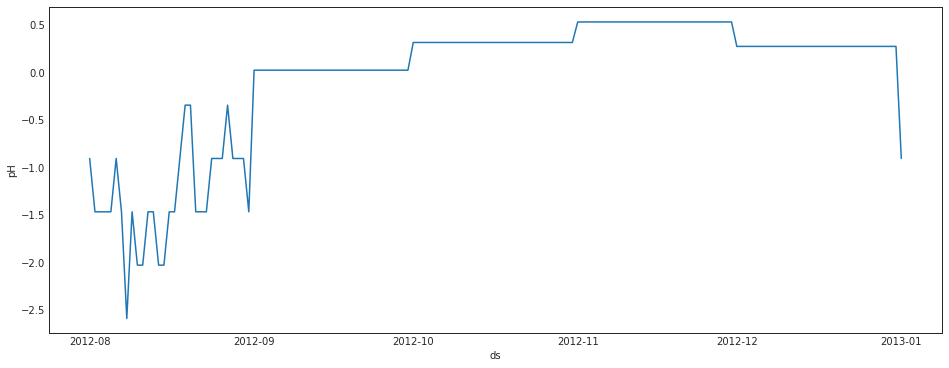

In [24]:
fig, ax=plt.subplots(figsize=(16,6))
sns.lineplot(ax=ax, data=df['pH']['2012-08-01':'2013-01-01'])

In [25]:
# Testing for Stationarity # Augmented Dickey-Fuller unit root test
from statsmodels.tsa.stattools import adfuller
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [26]:
for c in cols:
    print(c, ': ')
    adf_check(df[c])

pH : 
Stationary 0.001673785928159833
COD : 
Stationary 3.613236233642134e-08
SS : 
Stationary 0.000302929400331751
N : 
Stationary 0.00032986493239709223
P : 
Stationary 0.001790657963166489
T : 
Stationary 5.121764544239942e-08


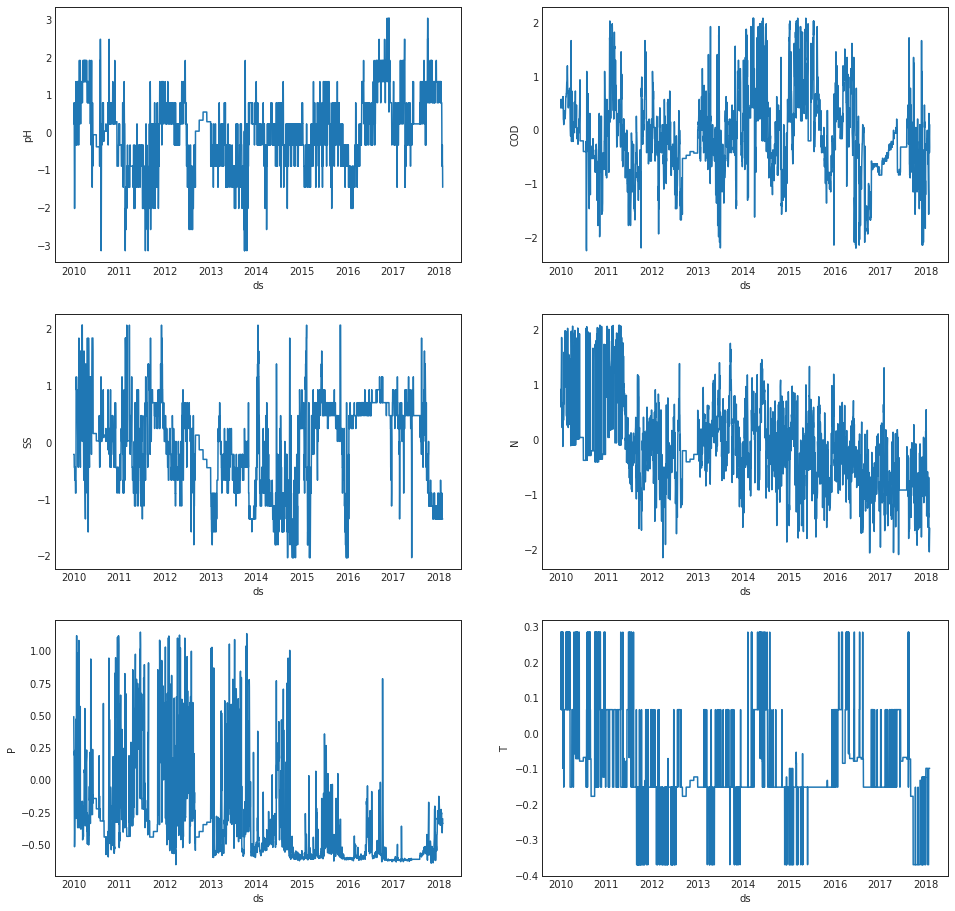

In [27]:
fig, ax = plt.subplots(3,2, figsize=(16,16))
for i,v in enumerate(cols):
    sns.lineplot(ax=ax[i//2][i%2], data=df[v])

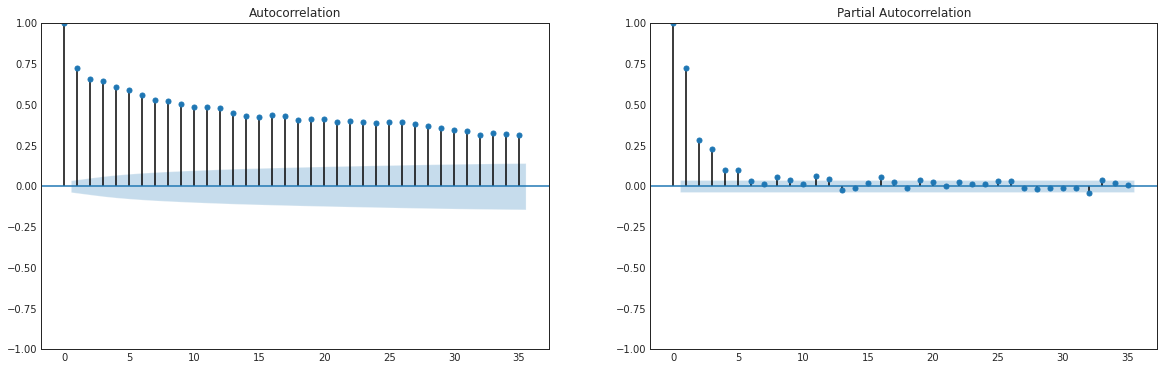

In [28]:
# acf, pacf
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_acf(df[v], ax=ax[0]); 
plot_pacf(df[v], ax=ax[1], method='ywm');

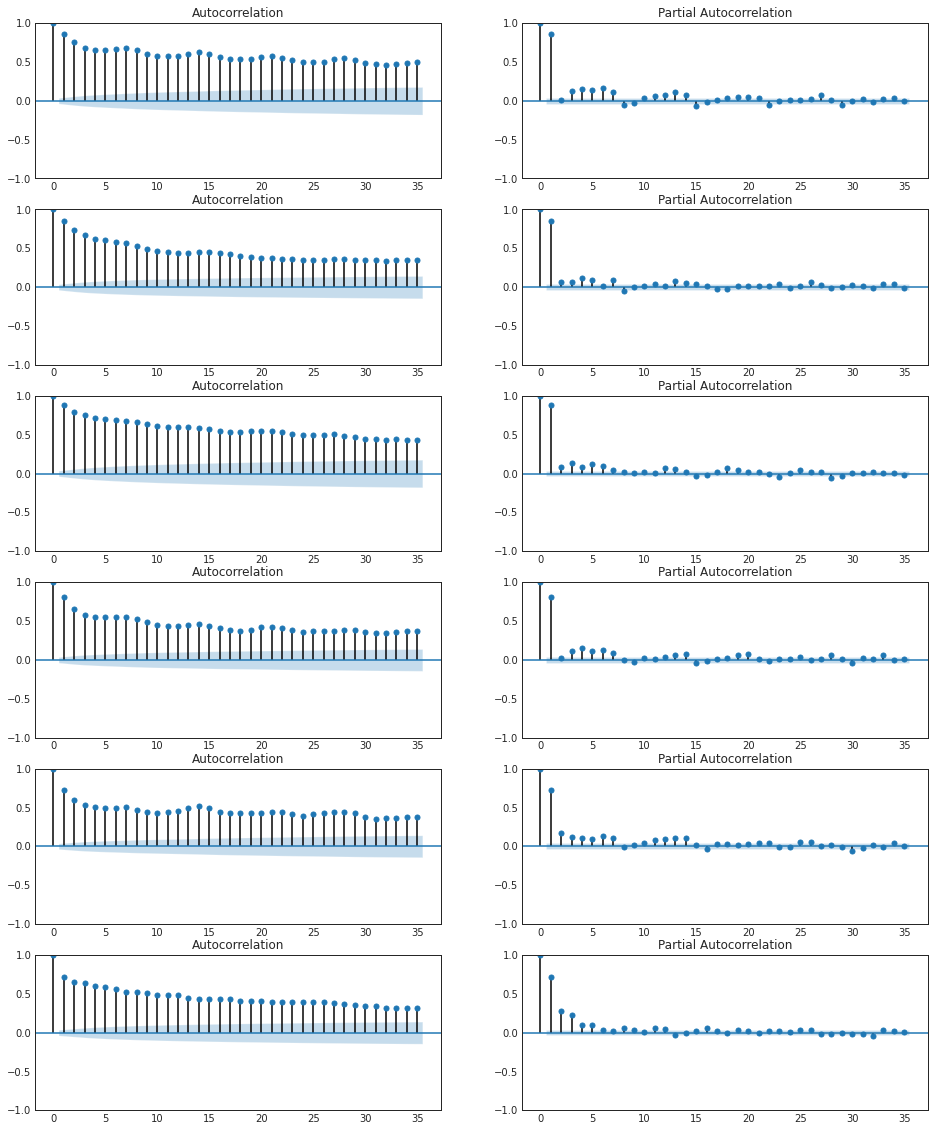

In [29]:
fig, ax = plt.subplots(6,2, figsize=(16,20))
for i,v in enumerate(cols):
    plot_acf(df[v], ax=ax[i][0]); 
    plot_pacf(df[v], ax=ax[i][1], method='ywm');

In [30]:
# stationary 한데, acf가 지수적으로 감소하지는 않음 -> auto로 가자

In [31]:
cols

['pH', 'COD', 'SS', 'N', 'P', 'T']

In [ ]:
pH_model_auto = auto_arima(df['pH'], start_p=1, start_q=0, 
                        max_p=3, max_q=3, seasonal=True,m=12,
                        d=1, D=1, 
                        max_P=3, max_Q=3,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6315.370, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5502.557, Time=1.73 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6309.840, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4994.633, Time=5.66 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=4726.791, Time=6.49 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=35.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=16.44 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=4757.450, Time=3.97 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=4621.247, Time=8.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4896.409, Time=4.58 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=47.73 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=22.51 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=45

In [ ]:
'''
ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.64 sec
ARIMA(0,1,0)(0,1,0)[12]             : AIC=6315.370, Time=0.20 sec
ARIMA(1,1,0)(1,1,0)[12]             : AIC=5502.557, Time=1.73 sec
ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.44 sec
ARIMA(1,1,0)(0,1,0)[12]             : AIC=6309.840, Time=0.21 sec
ARIMA(1,1,0)(2,1,0)[12]             : AIC=4994.633, Time=5.66 sec
ARIMA(1,1,0)(3,1,0)[12]             : AIC=4726.791, Time=6.49 sec
ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=35.66 sec
ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=16.44 sec
ARIMA(0,1,0)(3,1,0)[12]             : AIC=4757.450, Time=3.97 sec
ARIMA(2,1,0)(3,1,0)[12]             : AIC=4621.247, Time=8.80 sec
ARIMA(2,1,0)(2,1,0)[12]             : AIC=4896.409, Time=4.58 sec
ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=47.73 sec
ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=22.51 sec
ARIMA(3,1,0)(3,1,0)[12]             : AIC=4541.454, Time=8.64 sec
ARIMA(3,1,0)(2,1,0)[12]             : AIC=4800.945, Time=4.89 sec
ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=48.97 sec
ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=25.87 sec
ARIMA(3,1,1)(3,1,0)[12]             : AIC=4350.529, Time=18.40 sec
'''